In [ ]:
# =============================================================================
# SECCIÓN 1: INSTALACIÓN DE DEPENDENCIAS CON UV
# =============================================================================
import shutil

# Instalamos 'uv' en el sistema si no existe
if shutil.which("uv") is None:
    !pip install uv -q

# Utilizamos uv para instalar las librerías del proyecto de forma ultra rápida
!uv pip install --system pandas numpy scikit-learn matplotlib seaborn joblib requests

Using Python 3.12.12 environment at: /usr
Audited 7 packages in 118ms


In [ ]:
# =============================================================================
# SECCIÓN 2: CARGA DE DATOS (GITHUB REMOTE)
# =============================================================================

import pandas as pd

# URL del dataset en formato RAW para lectura directa
GITHUB_URL = "https://raw.githubusercontent.com/berniehans/ProjectEvo-Callao-Safety/main/data/v2_dataset_callao.csv"

try:
    df = pd.read_csv(GITHUB_URL, sep=';', encoding='latin1', usecols=['DESCRIPCION_OCURRENCIA', 'TIPOLOGIA'])
    print(f"✅ Dataset cargado exitosamente.")
    print(f"Dimensiones: {df.shape[0]} registros y {df.shape[1]} columnas.")
    display(df.head(3))
except Exception as e:
    print(f"❌ Error al cargar el dataset: {e}")

✅ Dataset cargado exitosamente.
Dimensiones: 98458 registros y 2 columnas.


,TIPOLOGIA,DESCRIPCION_OCURRENCIA
0,AMBIENTALES,"SIENDO LAS 16:54 PM, DEL DIA 22/10/2024, SE VE..."
1,AMBIENTALES,SIENDO LAS 15:57 HRS SE EJECUTA PATRULLAJE TEC...
2,AMBIENTALES,SIENDO LAS 15:55 HRS SE EJECUTA PATRULLAJE TEC...


/tmp/ipython-input-1300940332.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=LABEL_COL, order=order, palette='viridis')


📊 Distribución de Clases:
- AMBIENTALES : 28.83% (28389 registros)
- APOYO AL CIUDADANO : 21.53% (21198 registros)
- FISCALIZACION Y DEFENSA CIVIL : 17.36% (17091 registros)
- TRANSITO Y SEGURIDAD VIAL : 17.15% (16888 registros)
- SEGURIDAD : 13.46% (13248 registros)
- FISICA(SALUD) : 1.12% (1106 registros)
- PROTECCION FAMILIAR : 0.44% (429 registros)
- FISICA : 0.11% (109 registros)


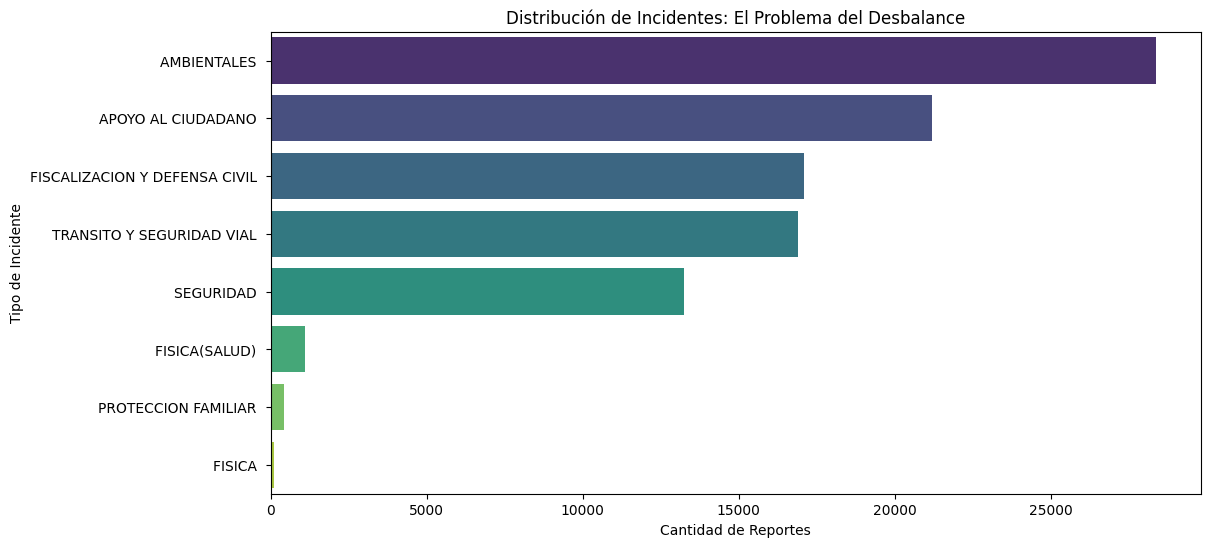

In [ ]:
# =============================================================================
# SECCIÓN 3: EDA - DISTRIBUCIÓN DE CATEGORÍAS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
order = df[LABEL_COL].value_counts().index
sns.countplot(data=df, y=LABEL_COL, order=order, palette='viridis')

# Cálculo de porcentajes para el reporte
counts = df[LABEL_COL].value_counts()
perc = df[LABEL_COL].value_counts(normalize=True) * 100

print("📊 Distribución de Clases:")
for label, p in perc.items():
    print(f"- {label}: {p:.2f}% ({counts[label]} registros)")

plt.title("Distribución de Incidentes: El Problema del Desbalance")
plt.xlabel("Cantidad de Reportes")
plt.ylabel("Tipo de Incidente")
plt.show()

/tmp/ipython-input-3375751503.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=LABEL_COL, y='word_count', data=df, ax=ax[1], palette='Set2')


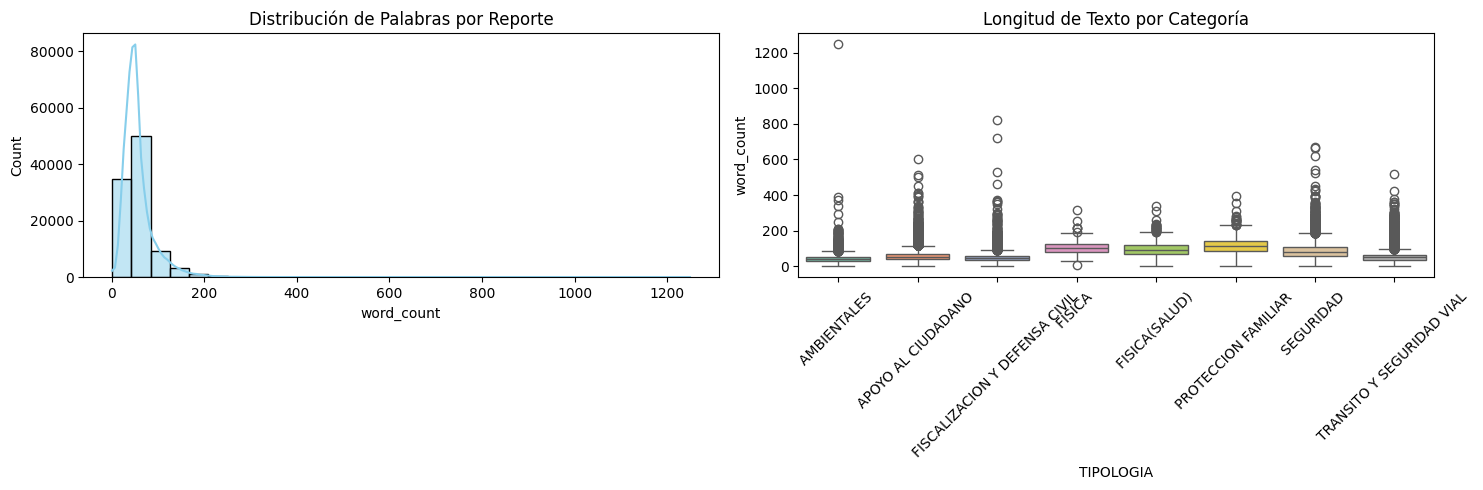

📝 Promedio de palabras por reporte: 57.29


In [ ]:
# =============================================================================
# SECCIÓN 4: EDA - LONGITUD DE LOS REPORTES (CARACTERES Y PALABRAS)
# =============================================================================

df['char_count'] = df[TEXT_COL].astype(str).apply(len)
df['word_count'] = df[TEXT_COL].astype(str).apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['word_count'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Distribución de Palabras por Reporte")

sns.boxplot(x=LABEL_COL, y='word_count', data=df, ax=ax[1], palette='Set2')
ax[1].set_title("Longitud de Texto por Categoría")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"📝 Promedio de palabras por reporte: {df['word_count'].mean():.2f}")

🔍 Analizando combinaciones de palabras frecuentes...


/tmp/ipython-input-504025038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Bigrama', data=common_words, palette='magma')


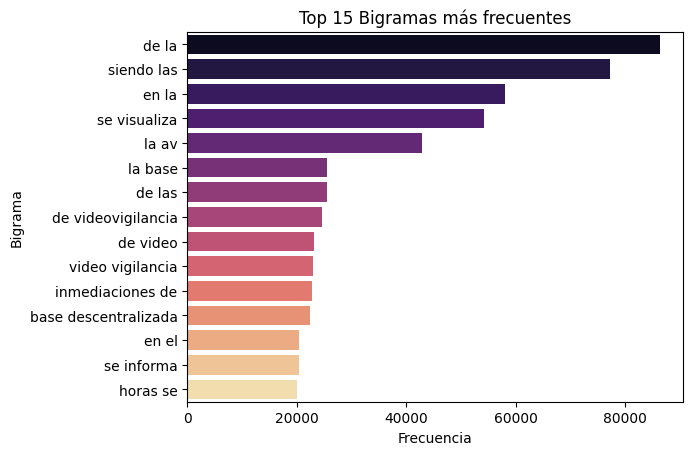

In [ ]:
# =============================================================================
# SECCIÓN 5: EDA - ANÁLISIS DE N-GRAMAS (BIGRAMAS)
# =============================================================================

from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(text, n=2, top_k=15):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    common_words = pd.DataFrame(words_freq[:top_k], columns=['Bigrama', 'Frecuencia'])
    sns.barplot(x='Frecuencia', y='Bigrama', data=common_words, palette='magma')
    plt.title(f"Top {top_k} Bigramas más frecuentes")
    plt.show()

print("🔍 Analizando combinaciones de palabras frecuentes...")
plot_top_ngrams(df[TEXT_COL].astype(str))

In [ ]:
# =============================================================================
# SECCIÓN 6: DIVISIÓN DE DATOS ESTRATIFICADA
# =============================================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COL].astype(str).str.lower(),
    df[LABEL_COL],
    test_size=0.2,
    random_state=42,
    stratify=df[LABEL_COL]
)

print(f"✅ Split completado. Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

✅ Split completado. Train: 78766 | Test: 19692


In [ ]:
# =============================================================================
# SECCIÓN 7: MODELO BASELINE (TF-IDF + LOGISTIC REGRESSION)
# =============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Vectorización
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 2. Modelo con balanceo de pesos manual (clásico)
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

# 3. Predicción
y_pred = model.predict(X_test_vec)

print("\n🎯 Resultados del Baseline (V1):")
print(classification_report(y_test, y_pred))


🎯 Resultados del Baseline (V1):
                                precision    recall  f1-score   support

                  AMBIENTALES        0.94      0.88      0.91      5678
           APOYO AL CIUDADANO        0.75      0.68      0.71      4240
FISCALIZACION Y DEFENSA CIVIL        0.82      0.84      0.83      3418
                       FISICA        0.16      0.36      0.22        22
                FISICA(SALUD)        0.37      0.84      0.52       221
          PROTECCION FAMILIAR        0.25      0.78      0.38        86
                    SEGURIDAD        0.73      0.79      0.76      2649
    TRANSITO Y SEGURIDAD VIAL        0.92      0.91      0.91      3378

                      accuracy                           0.82     19692
                     macro avg       0.62      0.76      0.65     19692
                  weighted avg       0.84      0.82      0.83     19692



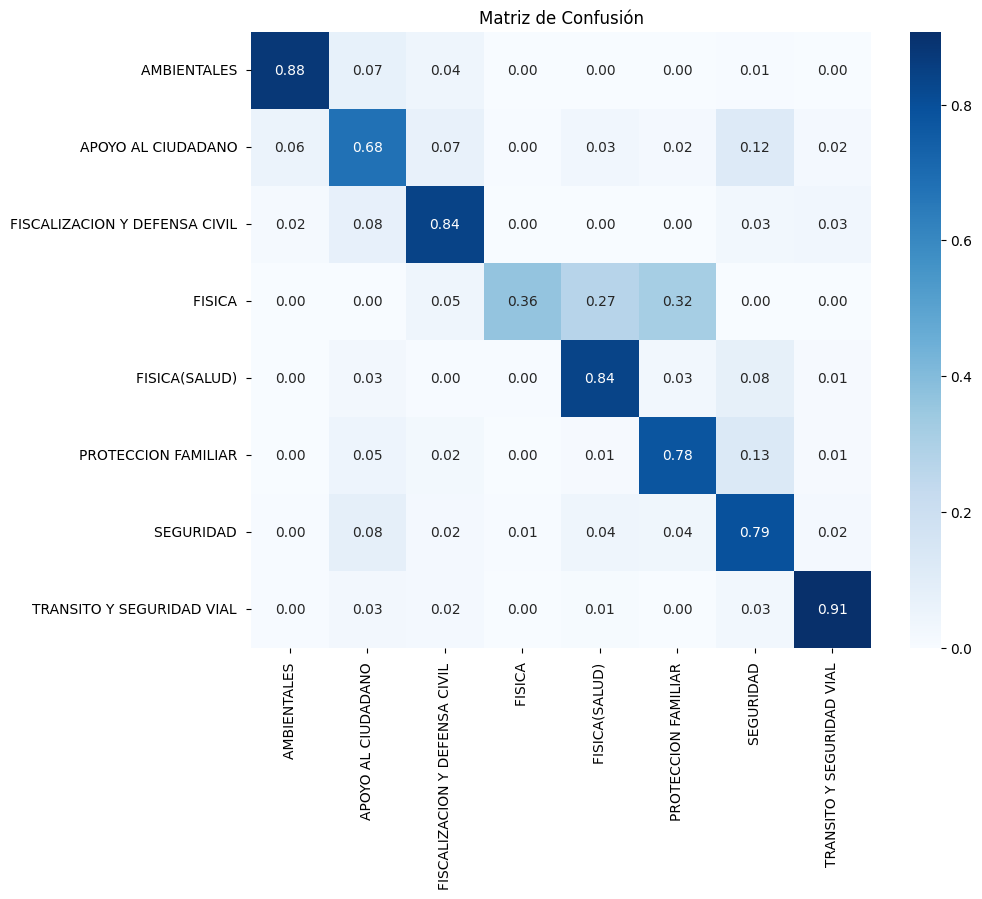

💾 Fase 1 completada.


In [ ]:
# =============================================================================
# SECCIÓN 8: MATRIZ DE CONFUSIÓN Y PERSISTENCIA
# =============================================================================

import joblib
import os

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Matriz de Confusión")
plt.show()

# Guardar artefactos
os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/baseline_model_v1.pkl')
joblib.dump(tfidf, 'models/tfidf_vectorizer_v1.pkl')

print("💾 Fase 1 completada.")